In [1]:
#importing torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
#importing other important Libraries
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import timm
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
from itertools import combinations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#train and test Dataloader 
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test=datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist, batch_size=7168, shuffle=True)
test_loader=DataLoader(mnist_test,batch_size=7168,shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 472kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.28MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.73MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
#Trained VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Load Pretrained ResNet-34 from timm
        self.encoder = timm.create_model("resnet34", pretrained=True, features_only=True,in_chans=1)
        self.encoder_out_dim = 2048  # ResNet-34 outputs 512 features
        
        # Latent layers (mean & variance)
        self.fc_mu = nn.Linear(self.encoder_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.encoder_out_dim, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 512 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output in range [0,1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Reparameterization trick

    def forward(self, x):
        features = self.encoder(x)[-1]  # Get final feature map
        features = features.view(features.size(0), -1)  # Flatten
        
        mu, logvar = self.fc_mu(features), self.fc_logvar(features)
        z = self.reparameterize(mu, logvar)
        
        x_recon = self.decoder(self.decoder_input(z).view(-1, 512, 4, 4))
        return x_recon, mu, logvar

vae=pickle.load(open('/kaggle/input/gsoc-vae-64/VAE_64.sav','rb'))
# vae=VAE()
for param in vae.parameters():
    param.requires_grad = False
vae=vae.to(device)

In [4]:
#Oracle model
class oracle(nn.Module):
    def __init__(self,vae):
        super().__init__()
        self.vae=vae
        self.orac=nn.Sequential(
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )

    def latent_vector(self,x):
        features=self.vae.encoder(x)[-1]
        features = features.view(features.size(0), -1)
        mu, logvar = self.vae.fc_mu(features), self.vae.fc_logvar(features)
        z = self.vae.reparameterize(mu, logvar)
        return z
    def forward(self,x):
        return self.orac(latent_vector(x))

orac=pickle.load(open('/kaggle/input/gsoc-e2e-oracle/Oracle.sav','rb'))
for param in orac.parameters():
    param.requires_grad = False
orac=orac.to(device)

In [5]:
#Helper Functions
def latent_vector(x):
    with torch.no_grad():
        features=vae.encoder(x)[-1]
        features = features.view(features.size(0), -1)
        mu, logvar = vae.fc_mu(features), vae.fc_logvar(features)
        z = vae.reparameterize(mu, logvar)
    return z

def decoder(z):
    with torch.no_grad():
        x_recon = vae.decoder(vae.decoder_input(z).view(-1, 512, 4, 4))
    return x_recon

In [6]:
orac = orac.to(device)
optimizer = optim.Adam(orac.parameters(), lr=0.001)
losses=nn.CrossEntropyLoss()

In [7]:
#training of oracle model
num_epochs=10
best=0
# Training loop
for epoch in range(num_epochs):
    orac.train()  # Set model to training mode
    train_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = orac(images)
        # print(outputs.shape,labels.shape)
        loss = losses(outputs, labels)
        # print(outputs)
        # print(labels)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        # break
    # scheduler.step()
    # Compute average training loss
    train_loss /= len(train_loader)

    # Validation loop
    orac.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    pred=[]
    label=[]
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = orac(images)
            # print(outputs.shape,labels.shape)
            loss = losses(outputs, labels)
            val_loss += loss.item()
            pred.append(torch.nn.Softmax(dim=1)(outputs).cpu().numpy())
            label.append(labels.cpu().numpy())
            # auc_score[i] += roc_auc_score(true_labels_one_hot[:, i], probabilities[:, i])
            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            # break
    predictions=np.concatenate(pred)
    label=np.concatenate(label)
    # Compute average validation loss & accuracy
    score =  roc_auc_score(label, predictions, multi_class="ovr")
    val_loss /= len(test_loader)
    val_acc = 100 * correct / (len(test_loader)*32)
    if score>best:
        best=score
        pickle.dump(orac, open('/kaggle/working/best_model.sav', 'wb'))
        
    # Print results
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val roc_auc: {score}")

100%|██████████| 157/157 [00:03<00:00, 47.65it/s]


Epoch [1/10] | Train Loss: 0.3845 | Val Loss: 0.1705 | Val roc_auc: 0.9980722877790429


100%|██████████| 157/157 [00:03<00:00, 48.94it/s]


Epoch [2/10] | Train Loss: 0.1582 | Val Loss: 0.1217 | Val roc_auc: 0.9989244051794396


100%|██████████| 157/157 [00:03<00:00, 49.10it/s]


Epoch [3/10] | Train Loss: 0.1213 | Val Loss: 0.0973 | Val roc_auc: 0.9992982342945057


100%|██████████| 157/157 [00:03<00:00, 48.98it/s]


Epoch [4/10] | Train Loss: 0.1012 | Val Loss: 0.0943 | Val roc_auc: 0.9993575624678745


100%|██████████| 157/157 [00:03<00:00, 49.41it/s]


Epoch [5/10] | Train Loss: 0.0925 | Val Loss: 0.0890 | Val roc_auc: 0.9994453048600527


100%|██████████| 157/157 [00:03<00:00, 49.17it/s]


Epoch [6/10] | Train Loss: 0.0831 | Val Loss: 0.0857 | Val roc_auc: 0.9995058516902928


100%|██████████| 157/157 [00:03<00:00, 48.70it/s]


Epoch [7/10] | Train Loss: 0.0764 | Val Loss: 0.0772 | Val roc_auc: 0.9995689841866808


100%|██████████| 157/157 [00:03<00:00, 48.86it/s]


Epoch [8/10] | Train Loss: 0.0721 | Val Loss: 0.0760 | Val roc_auc: 0.9995727278718002


100%|██████████| 157/157 [00:03<00:00, 49.05it/s]


Epoch [9/10] | Train Loss: 0.0693 | Val Loss: 0.0708 | Val roc_auc: 0.9996460603327169


100%|██████████| 157/157 [00:03<00:00, 48.60it/s]

Epoch [10/10] | Train Loss: 0.0687 | Val Loss: 0.0746 | Val roc_auc: 0.9995407691122364


In [31]:
#generator model 
class generator(nn.Module):
    def __init__(self,vae,n_generators):
        super().__init__()
        self.vae=vae
        self.gen=[nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU(),
            # nn.Linear(32,16),
            # nn.ReLU(),
            # nn.Linear(16,32),
            # nn.ReLU(),
            nn.Linear(32,64),
        ).to(device) for _ in range(n_generators)]

    def latent_vector(self,x):
        with torch.no_grad():
            features=self.vae.encoder(x)[-1]
            features = features.view(features.size(0), -1)
            mu, logvar = self.vae.fc_mu(features), self.vae.fc_logvar(features)
            z = self.vae.reparameterize(mu, logvar)
        return z
    def forward(self,x):
        z=self.latent_vector(x)
        outputs=[]
        for ge in self.gen:
            outputs.append(ge(z))
        return outputs

gen=generator(vae,4)
gen=pickle.load(open('/kaggle/input/gen/gen.sav','rb'))
# vae=VAE()
for param in vae.parameters():
    param.requires_grad = False
vae=vae.to(device)

In [32]:
#Custom Loss from the paper
def custom_loss(x, ge, eps, oracle=orac):
    def normalized_dot(a, b):
        return torch.sum(a * b, dim=1) / (torch.norm(a, dim=1) * torch.norm(b, dim=1) + 1e-16)

    loss1 = 0
    loss2 = 0
    loss3 = 0

    for genx in ge:
        out1 = oracle.orac(x + eps * genx)
        out2 = oracle.orac(x)
        loss1 += torch.mean((out2 - out1) ** 2) / eps**2
        loss2 += (torch.norm(genx, dim=1).mean() - 1) ** 2 + torch.norm(genx, dim=1).std()

    for i, j in combinations(range(len(ge)), 2):
        loss3 += torch.mean(normalized_dot(ge[i], ge[j])**2)

    return loss1 + loss2 + loss3


In [35]:
gen = gen.to(device)
optimizer = optim.Adam(orac.parameters(), lr=0.0001)

In [36]:
#training of generator model
num_epochs=10
best=1000000000.0
# Training loop
for epoch in range(num_epochs):
    gen.train()  # Set model to training mode
    train_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        genx=gen(images)
        x=gen.latent_vector(images)
        loss = custom_loss(x,genx,1e-3)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    orac.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            genx=gen(images)
            x=gen.latent_vector(images)
            loss = custom_loss(x,genx,1e-3)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    if best>val_loss:
        best=val_loss
        pickle.dump(orac, open('/kaggle/working/best_model.sav', 'wb'))
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


Epoch [1/10] | Train Loss: 14.1970 | Val Loss: 14.1572


100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


Epoch [2/10] | Train Loss: 14.1986 | Val Loss: 14.1832


 11%|█         | 1/9 [00:05<00:47,  5.91s/it]


KeyboardInterrupt: 

In [37]:
test_images, _ = next(iter(test_loader))

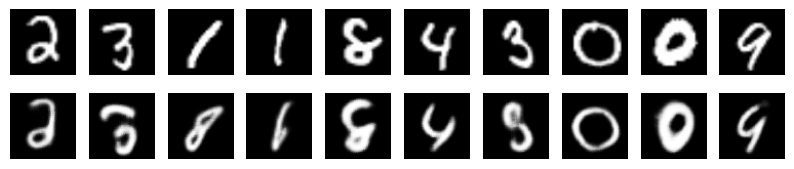

In [39]:
gen.eval()
with torch.no_grad():
    # test_images,_=rotate_image(test_images)
    test_images = test_images.to(device)# Reconstruct images
    genx=gen(test_images)[3]
    x=gen.latent_vector(test_images)
    # recon_images=decoder(x+1e-3*genx)
    # print(x)
    for i in range(1999):
        genx=gen.gen[3](x+1e-3*genx)
        x=x+1e-3*genx
        # recon_images=decoder(x+1e-3*genx)
    # Plot original and reconstructed images
    # print(x)
    recon_images=decoder(x+genx)
    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap="gray")  # Original
        axes[1, i].imshow(recon_images[i].cpu().squeeze(), cmap="gray")  # Reconstructed
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    plt.show()

In [40]:
# del plat_one

In [41]:
cnt=0
plat_one=[]
for image , label in tqdm(mnist):
    if label==1:
        image=image.to(device).unsqueeze(0)
        z=latent_vector(image).squeeze()
        cnt+=1
        # print(z)
        # break
            
        plat_one.append(z)

plat_one=torch.mean(torch.stack(plat_one),dim=0)
plat_img=decoder(plat_one.unsqueeze(0))
plt.imshow(plat_img.cpu().squeeze(), cmap="gray")

100%|██████████| 60000/60000 [00:39<00:00, 1511.40it/s]


100%|██████████| 1999/1999 [00:00<00:00, 9517.60it/s]


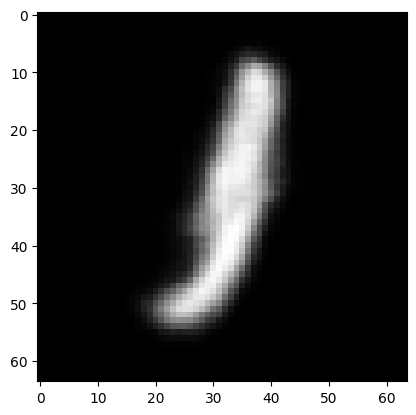

In [54]:
## gen.eval()
with torch.no_grad():
    plat_one=plat_one.unsqueeze(0)
    
    genx=gen.gen[3](plat_one)
    # print(genx)
    x=plat_one-1e-3*genx
    for i in tqdm(range(1999)):
        genx=gen.gen[0](x)
        x=x-1e-3*genx
    plat_img=decoder(x)
    plt.imshow(plat_img.cpu().squeeze(), cmap="gray")